## Part 2: SVM

This is part 2 of my Binary Classification Comparison project. In my last post, I created an XGBoost model to predict history of high blood pressure using the CDC's <a href="https://www.cdc.gov/brfss/annual_data/annual_2017.html" target="_blank">2017 Behavioral Risk Factor Surveillance System dataset</a>. Now I'll train a support vector machine to accomplish the same task. Given that the number of observations >> the number of predictors and that our features are not not very discriminative, I'm not expecting performance to be all that different than the XGBoost model. Still, it's a fun exercise.

## Model specification

Given that n is quite large, using a gaussian or similar kernels isn't really an option, so we're left with using linear SVM (LinearSVC in sklearn).

Given the nature of the data and the train/validation performance of XGBoost, I'm not anticipating a lot of issues with overfitting. We'll still try out a few values of C to optimize the algorithm as best we can. Again, I could use k-fold cross validation with GridSearch from sklearn, but for simplicity I'm just going to use the same validation set as last time and code it myself.

In [1]:
# Import train/val
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt

x_train = pickle.load( open( "x_train.pickle", "rb" ) )
x_val = pickle.load( open( "x_val.pickle", "rb" ) )
y_train = pickle.load( open( "y_train.pickle", "rb" ) )
y_val = pickle.load( open( "y_val.pickle", "rb" ) )
# Variables (selected previously)
keep_vars10 = pickle.load( open( "keep_vars10.pickle", "rb" ) )

# Make list of C values
c_vals = [10**float(i) for i in np.arange(-4,3)]

# Save models by C value
m_list = []
for i in c_vals:
    m_list.append(LinearSVC(C=i,dual=False).fit(x_train[keep_vars10],y_train))

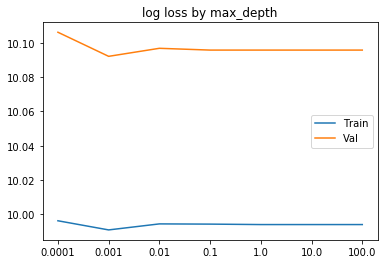

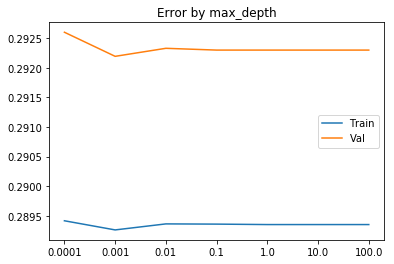

In [2]:
plt.plot([str(i) for i in c_vals],
        [log_loss(y_train,i.predict(x_train[keep_vars10])) \
        for i in m_list])
plt.plot([str(i) for i in c_vals],
        [log_loss(y_val,i.predict(x_val[keep_vars10])) \
        for i in m_list])
plt.title(label='log loss by max_depth')
plt.legend(['Train', 'Val'])
plt.show()

plt.plot([str(i) for i in c_vals],
        [1-accuracy_score(y_train,i.predict(x_train[keep_vars10])) \
        for i in m_list])
plt.plot([str(i) for i in c_vals],
        [1-accuracy_score(y_val,i.predict(x_val[keep_vars10])) \
        for i in m_list])
plt.title(label='Error by max_depth')
plt.legend(['Train', 'Val'])
plt.show()

As expected, C doesn't affect performance much. But it looks (very) marginally better at .001. Let's take a look at precision/recall for that model.

In [3]:
print('Train')
print(confusion_matrix(y_train,m_list[1].predict(x_train[keep_vars10])))
print(classification_report(y_train,m_list[1].predict(x_train[keep_vars10])))

print('Validation')
print(confusion_matrix(y_val,m_list[1].predict(x_val[keep_vars10])))
print(classification_report(y_val,m_list[1].predict(x_val[keep_vars10])))

Train
[[123233  34199]
 [ 42526  65287]]
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76    157432
         1.0       0.66      0.61      0.63    107813

   micro avg       0.71      0.71      0.71    265245
   macro avg       0.70      0.69      0.70    265245
weighted avg       0.71      0.71      0.71    265245

Validation
[[30657  8674]
 [10702 16279]]
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76     39331
         1.0       0.65      0.60      0.63     26981

   micro avg       0.71      0.71      0.71     66312
   macro avg       0.70      0.69      0.69     66312
weighted avg       0.71      0.71      0.71     66312



This model doesn't take the imbalance into account. Just like with the XGBoost model, I'll specify the appropriate weight and see how that changes performance.

In [5]:
svc_bal = LinearSVC(C=.001,dual=False,
                    class_weight={1.0:sum(y_train==0)/sum(y_train==1)})
svc_bal.fit(x_train[keep_vars10],y_train)

print('Train')
print(confusion_matrix(y_train,svc_bal.predict(x_train[keep_vars10])))
print(classification_report(y_train,svc_bal.predict(x_train[keep_vars10])))

print('Validation')
print(confusion_matrix(y_val,svc_bal.predict(x_val[keep_vars10])))
print(classification_report(y_val,svc_bal.predict(x_val[keep_vars10])))

Train
[[104288  53144]
 [ 25925  81888]]
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.73    157432
         1.0       0.61      0.76      0.67    107813

   micro avg       0.70      0.70      0.70    265245
   macro avg       0.70      0.71      0.70    265245
weighted avg       0.72      0.70      0.70    265245

Validation
[[25859 13472]
 [ 6535 20446]]
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72     39331
         1.0       0.60      0.76      0.67     26981

   micro avg       0.70      0.70      0.70     66312
   macro avg       0.70      0.71      0.70     66312
weighted avg       0.72      0.70      0.70     66312



We see a similar precision/recall tradeoff that we observed with the XGBoost models with and without accounting for class weights. Overall, the performance was very similar to XGBoost. While precision isn't stellar, 76% recall isn't too bad. I'll save both models to add to the comparisons with the test sets later on. Up next, I'll train a simple logistic regression model.

In [6]:
pickle.dump(m_list[1], open('svc_unbal.pickle', 'wb'))
pickle.dump(svc_bal, open('svc_bal.pickle', 'wb'))